In [4]:
from aux_tutorials import *

# Define woking directories
data_folder, results_folder, figs_folder = set_working_directories('circle')

# Load dataset
mat = load_from_mat_file(data_folder + 'circle_data.mat')
Ux, Uy, P = [mat[key] for key in ['ux', 'uy', 'pp']]


Ux_noisy, Uy_noisy = add_noise_to_flow(Ux, Uy, 
                                       noise_level=0.1, 
                                       noise_type="gauss",
                                       spatial_smooth=0.1)


data = np.array([Ux_noisy, Uy_noisy])

all_data = data.transpose(0,3,2,1)
Nt_train = 400

X_train = all_data[..., :Nt_train].copy()
X_test = all_data[..., Nt_train:].copy()


# This is the _true_ data, which is never seen by the POD-ESN
data_true = np.array([Ux, Uy])
all_data_true = data_true.transpose(0,3,2,1)
X_test_true = all_data_true[..., Nt_train:].copy()


# # Visualize the flow fields
# anim = animate_flowfields([Ux_noisy, Uy_noisy], titles=['$U_x$', '$U_y$'])
# anim



# Part I. State estimation
- The data provided is used to perform the POD decomposition as well as the ESN training on the POD coefficients.
- If the flag ```train_ESN=False```, only the POD is perfromed and the ESN is not trained

In [5]:
from src.models_datadriven import POD_ESN
case_ESN = POD_ESN(data=X_train, 
                   N_modes=4, 
                   domain  = [-2, 2, 0, 12],
                   plot_case=False,
                   # ====== ESN arguments ======== # 
                   train_ESN=True,
                   N_train=.8* Nt_train,
                   N_val=.2*Nt_train,
                   N_wash=10,
                   noise=0.1,
                   N_func_evals=26,
                   rho_range=[0.2, 0.9],
                   upsample=2,
                    perform_test = False,
                  )
case_ESN_og = case_ESN.copy()

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...

 Computing Temporal correlation matrix K ...

 Done.
Computing Temporal Basis...
diagonalizing K....
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.
seed 0 	 Optimal hyperparameters: [0.2, -0.3010299956639812], 1e-06, MSE: -1.524103324846172
========= POD-ESN model complete =========


## 4. Test forecast of the POD-ESN
We can visualize:
- The temporal evolution of the POD coefficients
- The reconstruction of the flow and its MSE 

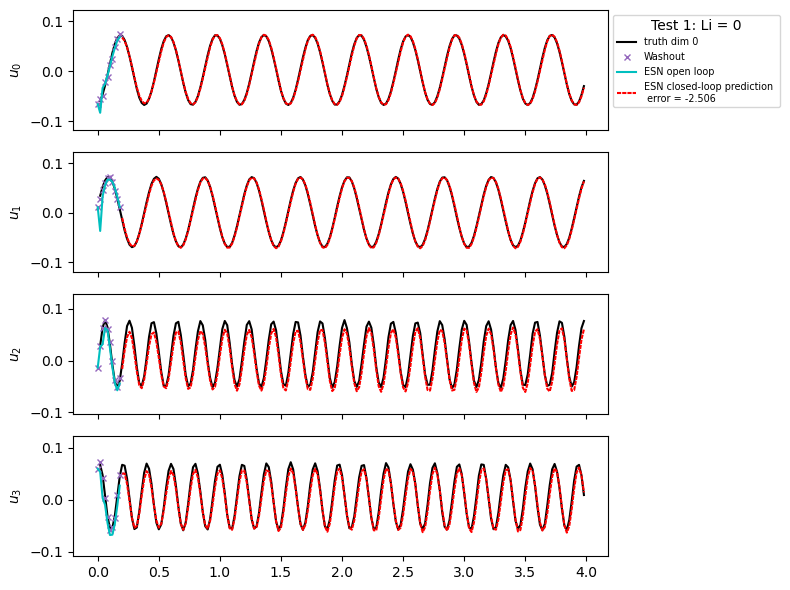

Overall tests min, max and mean MSE in 1 tests = -2.506, -2.506, -2.506.


In [17]:


U_test = X_test.reshape(case_ESN.Q_mean.shape[0], -1) - case_ESN.Q_mean

# Compare the POD coefficients
Phi_true = case_ESN.project_data_onto_Psi(data=U_test)
Phi_noisy = add_noise_to_data(Phi_true.copy(), noise_level=0.1)


case_ESN.run_test(U_test=Phi_noisy[::case_ESN.upsample],
                  Y_test=Phi_true[::case_ESN.upsample], 
                  Nt_test=len(Phi_noisy), 
                  max_L_tests=1, 
                  margin=0.05)


# Part III. Ensemble of POD_ESN as a Model instance

- Initilaize the ensemble with ```create_ensemble``` function, similar to previous tutorials
- Once  initialized, we can forecast the ensemble of POD-ESN. It is worth noting that the ESN model is not parallelized in ensemble mode as the ensemble forecast merely consists of matrix multiplications.

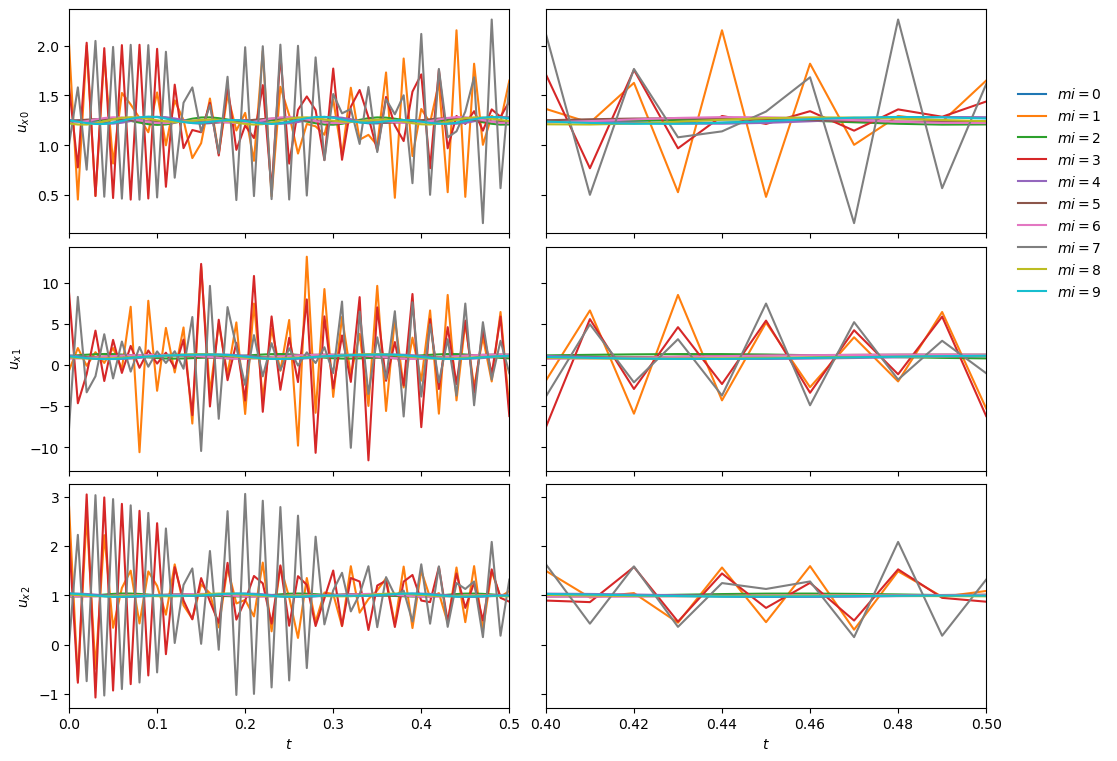

In [7]:
from src.create import create_ensemble

ensemble = create_ensemble(model=case_ESN,
                           m=10,
                           std_psi=1.5)

# Forecast the ensemble
psi, t = ensemble.time_integrate(Nt=100)
ensemble.update_history(psi, t)

# Visualize the time evolution of the physical states
plot_timeseries(ensemble, zoom_window=[0.4, 0.5], dims=[0,1,2])




## Singular value decomposition of Wout
We can decompose the trained Wout into its singular value components using the library ```scipy.linalg```. The multiplication of the three matrices are equivalent to the original Wout. 

Dimensions of matrices: (51, 4) (4,) (4, 4)


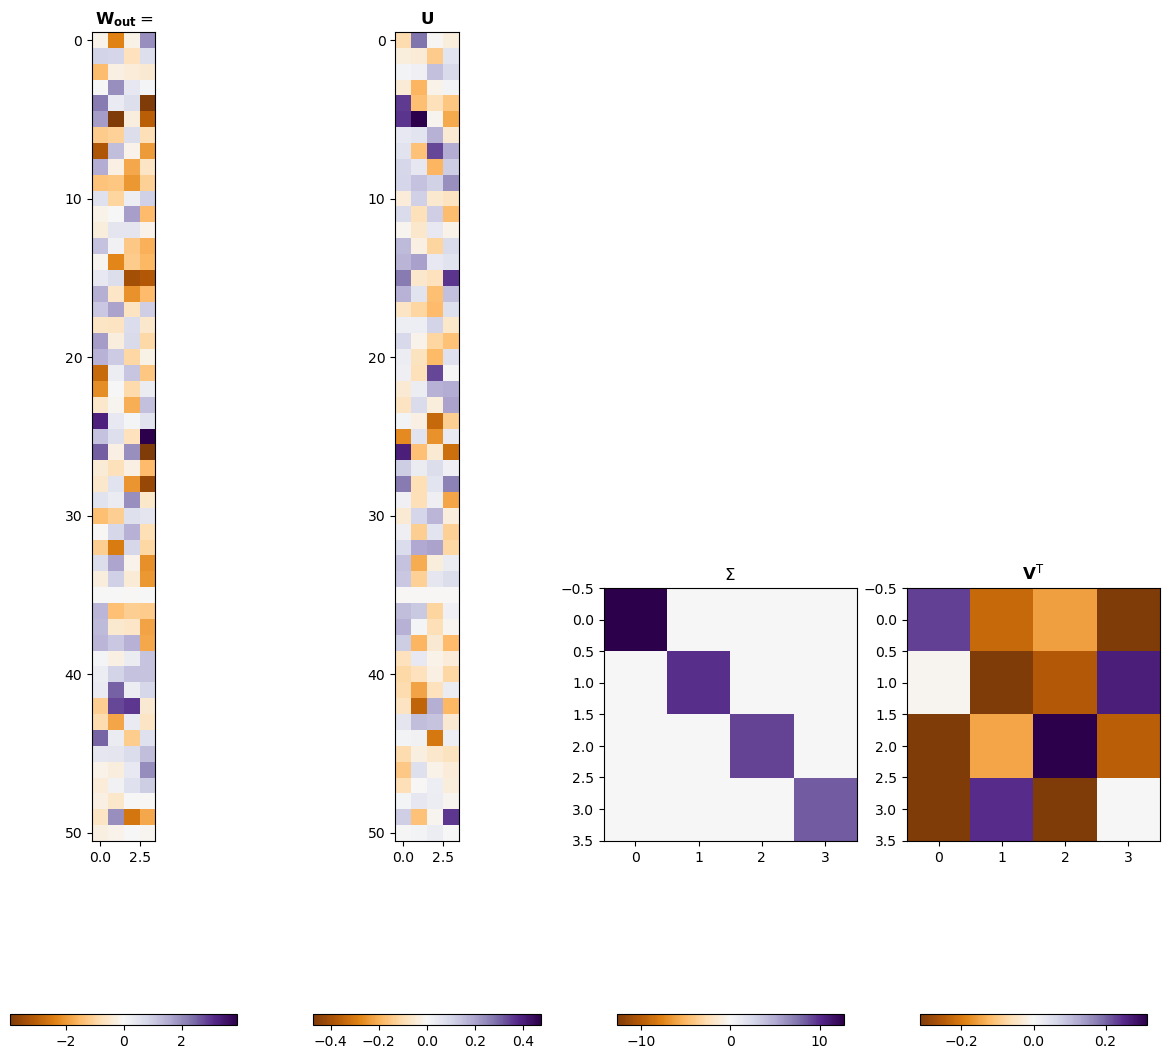

In [8]:
import scipy.linalg as sla

# Compute the SVD of the output matrix
[Wout_U, Wout_eigs, Wout_Vh] = sla.svd(ensemble.Wout, full_matrices=False)

#display the three matrices
fig, axs = plt.subplots(1, 4, figsize=(15, 15), width_ratios=[1, 1, 1, 1])
for W, ax, title in zip([ensemble.Wout, Wout_U, np.diag(Wout_eigs), Wout_Vh], axs, 
                        ['$\\mathbf{W_{out}} = $', '$\\mathbf{U}$', '$\\Sigma$', '$\\mathbf{V}^\\mathrm{T}$']):
    im = ax.imshow(W, cmap='PuOr', vmin=-np.max(W), vmax=np.max(W))
    ax.set(title=title)
    # set the same colorbar for all the matrices
    fig.colorbar(im, ax=ax, shrink=.9, orientation='horizontal')

print('Dimensions of matrices:', Wout_U.shape, Wout_eigs.shape, Wout_Vh.shape)

assert np.allclose(ensemble.Wout, np.dot(Wout_U, np.dot(np.diag(Wout_eigs), Wout_Vh)))

In [9]:
# Check that the SVD decomposition is correct, also when dealing with an ensemlbe of Wout matrices
ensemble_Wout = np.tile(ensemble.Wout, (ensemble.m, 1, 1))

#  ensemble of signular values
ensemble_Wout_eigs = np.tile(Wout_eigs, (ensemble.m, 1))
ensemble_Wout_eigs = np.array([np.diag(eigs) for eigs in ensemble_Wout_eigs])  ## this will be needed for the parameter estimation

assert np.allclose(ensemble_Wout.transpose(1,2,0), np.dot(Wout_U, np.dot(ensemble_Wout_eigs, Wout_Vh)).transpose(0,2,1))

## Parameter estimation: online learning of Wout
Why us the SVD interesting in this scenario? Because we can use data assimialtion to modify on the fly the value of the singluar values. This is, we can perform state and parameter inference with the ESN on the fly. In machine learning jargon, this is known as *online learning*.

With this objective, we first need to create an ensemble of POD-ESN with different SVDs for each ensemble member. This is achieved by providing `Wout` as the parameter to estimate, i.e., as the `est_a` argument. The `sta_a` parameter indicates the uncewrtainty around the Wout SVDs.


In [10]:
case_ESN.N, case_ESN.m, case_ESN.N_modes, case_ESN.N_func_evals

(74, 1, 4, 26)

In [11]:
from src.create import create_ensemble
ensemble = create_ensemble(model=case_ESN_og,
                           m=10,
                          std_psi=.5,
                          est_a=['Wout'],
                          std_a=0.2)



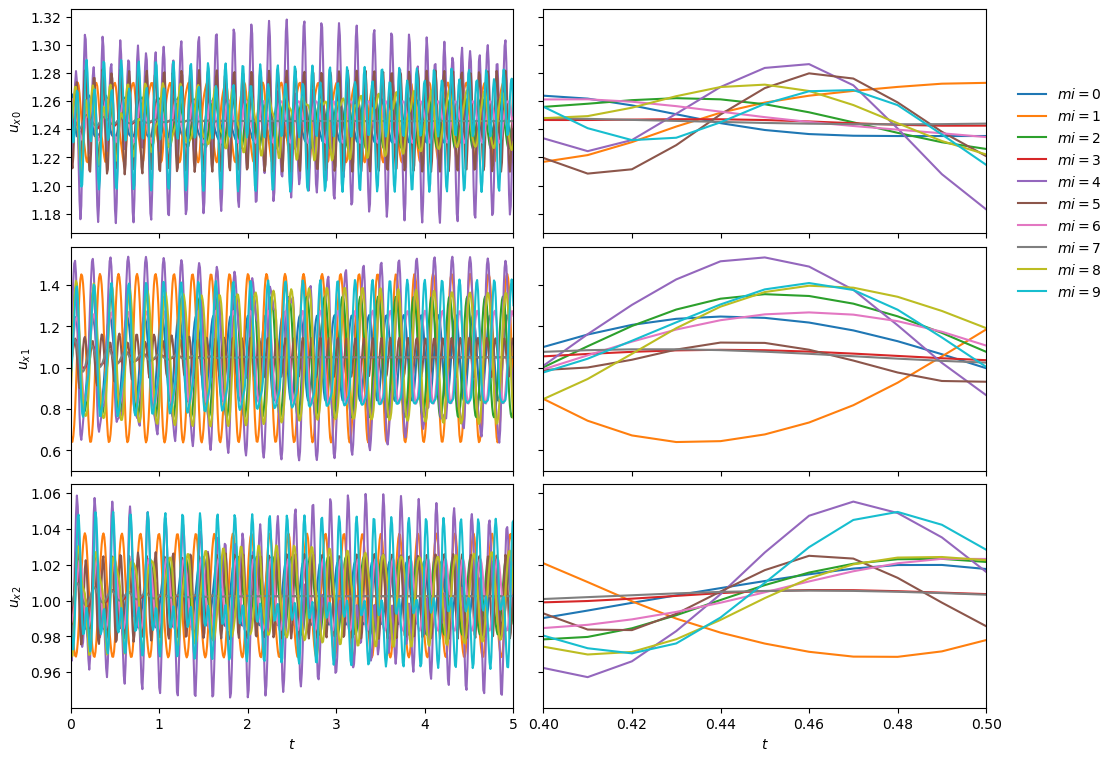

In [16]:

# Forecast the ensemble
psi, t = ensemble.time_integrate(Nt=500)
ensemble.update_history(psi, t)

# Visualize the time evolution of the physical states
plot_timeseries(ensemble, zoom_window=[0.4, 0.5], dims=[0,1,2])

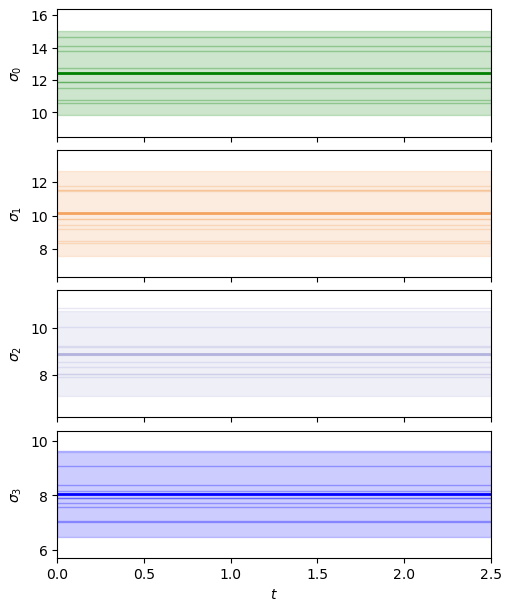

In [13]:
if ensemble.Na > 0:
    plot_parameters(ensemble)

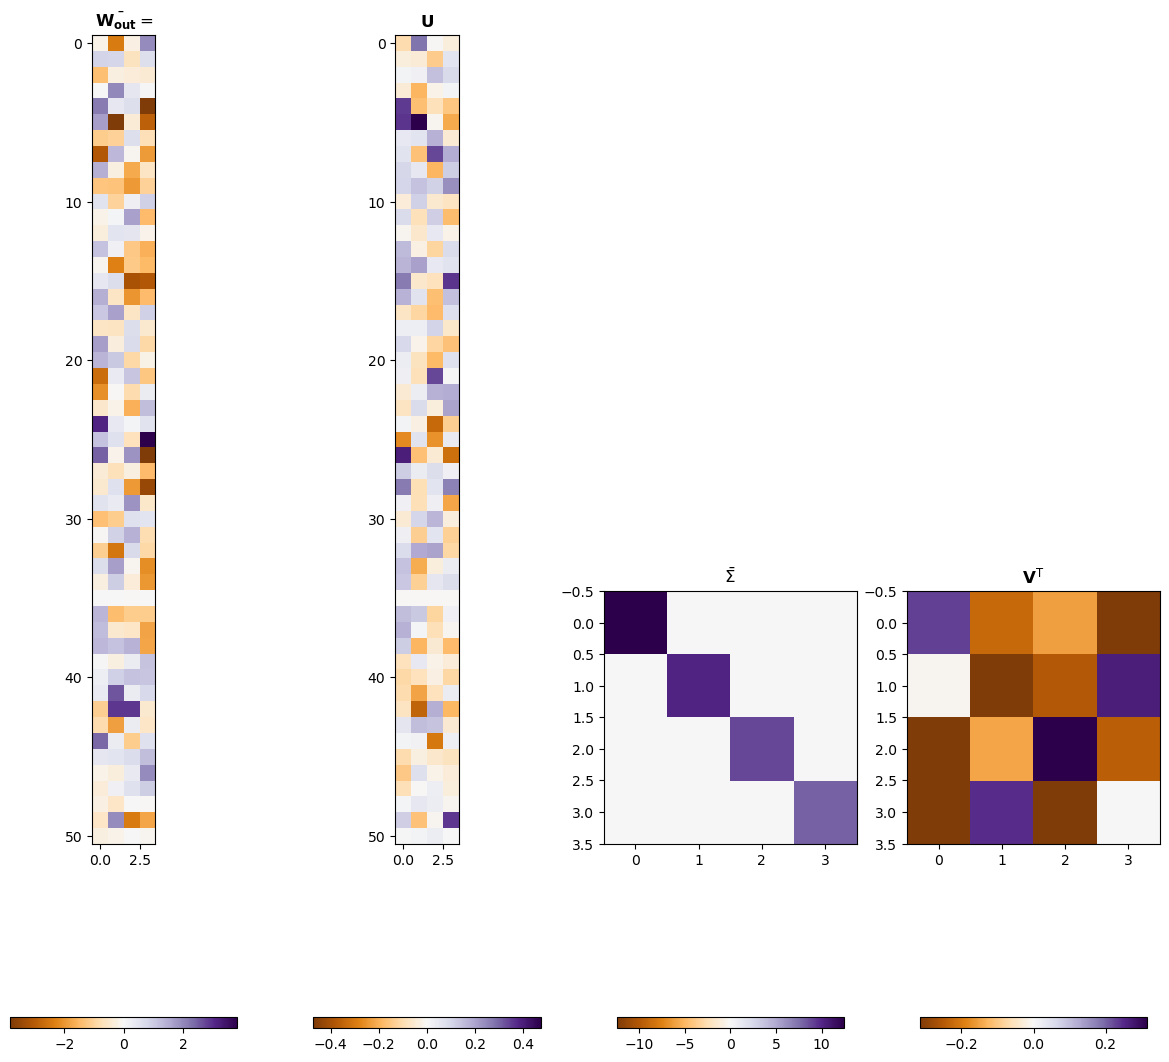

In [14]:
ensemble.plot_Wout()

In [15]:
ensemble.Wout_Sigma0

array([12.72166385,  9.85691896,  9.21489477,  8.44368719])

In [ ]:
# TODO: finish this notebook